# Wilks' Theorem

In lectures, we saw how Wilks' theorem can be used to obtain intervals when using a profiled likelihood ratio as our test statistic. 

Suppose we have an analysis in which the number of events in bins of a distribution is counted. There is a background process and two signal processes with signal strength modifiers $\mu_1$ and $\mu_2$, with no restrictions on their range. Our log-likelihood function for this will be, 

$$
    q(\mu_1,\mu_2,\eta) = -2 \left(\sum_{i} n\ln{\lambda_{i}}- \lambda_{i} \right) + \delta_{b}^{2},
$$

where $i$ runs over the bins, $\lambda_{i}=\mu_{1}s_{i,1}+\mu_{2}s_{i,2}+b_{i}(1+k_{i})^{\delta_{b}}$, and $\delta_{b}$ is a nuisance parameter which can change the slope of the background (due to the $\kappa_{i}$ being different for each bin).


The background, signal and data distributions are shown below

![LikelihoodShapeFit](figs/data_model_plot.png)

The model is defined by specifying the bin contents, and the nominal value of our nuisance parameter as follows.

In [1]:
import numpy
import sys
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})

signal1_counts    = numpy.array([0,0,0,0.5,1,2,3,4,5,4.5,4.0,3.5,3.0,2.5,2,1.5,1,0.5,0,0,0,0,0,0,0])
signal2_counts    = numpy.array([0,0,1,2,3,4,5,6,5,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
background_counts = numpy.array([60*numpy.exp(-0.1*i) for i in range(len(signal1_counts))])
bkg_uncert        = numpy.array([0.3,0.3,0.3,0.2,0.2,0.2,0.2,0.2,0.2,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.05,0.05,0.05,0.05,0.02,0.02,0.02,0.02])

nbins = len(signal1_counts)

# data = [[bin_contents],delta_b_0] 
data = [numpy.array([65, 45, 47, 37, 37, 40, 42, 36, 34, 36, 22, 23, 23, 18, 17, 13, 12, 12, 11, 12, 6, 6, 6, 9, 4]), 0]

nbins = len(data[0])

# now define the Poisson means
@numpy.vectorize
def lamb(s1,s2,delta_b,b,k):
  return s1+s2+b*(1+k)**delta_b

@numpy.vectorize
def log_poisson(data_in,signal1,signal2,background,bkg_u,mu1,mu2,delta_b):
  l = lamb(mu1*signal1,mu2*signal2,delta_b,background,bkg_u)
  return data_in*numpy.log(l) - l

First we need to define our functions to evaluate $q$, and (since we are profiling) find the profiled value of our nuisance parameter $\delta_{b}$. 

In [2]:
from scipy.optimize import minimize

def q(data,mu1,mu2,delta_b):
  constr = (data[1]-delta_b)**2
  return constr -2*sum(log_poisson(data[0],signal1_counts,signal2_counts,\
                        background_counts,bkg_uncert,mu1,mu2,delta_b)) 

def q_unconstrained(x, args):
  mu1, mu2, delta_b = x[0], x[1], x[2]
  #data = args[0]
  return q(args,mu1,mu2,delta_b)

def q_constrained(x, args):
  delta_b = x[0]
  data, mu1, mu2 = args[0], args[1], args[2]
  return q(data,mu1,mu2,delta_b)

def profiled_nuis(data, mu1, mu2):
  init_params = [-3.0]
  bounds =  [(-5,5)]
  res = minimize(q_constrained,init_params,args=[data,mu1,mu2],bounds=bounds)
  return res.x[0]

def global_min(data):
  init_params = [0.1,0.1,-3.]
  bounds = [(-10,10),(-10,10),(-5,5)]
  mle = minimize(q_unconstrained,init_params,args=data,bounds=bounds)
  return mle.fun,mle.x[0],mle.x[1]

def delta_q(data,mu1,mu2,q_min):
  q_value        = q(data,mu1,mu2,profiled_nuis(data,mu1,mu2))
  return q_value-q_min

First, let's find the profiled value of our two  signal strengths (these are the values used in the figure above).

In [3]:
q_min,mu1_min,mu2_min   = global_min(data)
print("minimum of q = ",q_min," for mu_1=",mu1_min,"mu_2=",mu2_min)

minimum of q =  -2948.5891171994185  for mu_1= 1.104373973939236 mu_2= 0.7087954565327468


Next, we scan the value of, 

$$
\Delta q(\mu_1,\mu_2) =  q(\mu_1,\mu_2,\hat{\eta}_{\mu_1,\mu_2}) - q(\hat{\mu}_1,\hat{\mu}_2,\hat{\eta}).
$$

in  a 2D grid

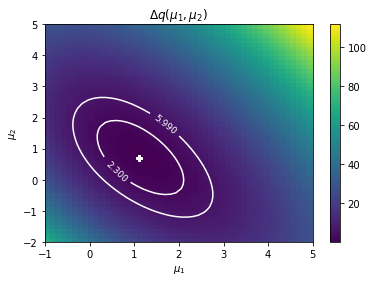

In [4]:
mu1_axis = numpy.linspace(-1,5,50)
mu2_axis = numpy.linspace(-2,5,50)
z = [ [delta_q(data,m1,m2,q_min) for m1 in mu1_axis] for m2 in mu2_axis]

X,Y = numpy.meshgrid(mu1_axis,mu2_axis)
c = plt.pcolor(X,Y,z)
plt.colorbar(c)
conts = plt.contour(X,Y,z,[2.3,5.99],colors="white")
plt.clabel(conts, fontsize=9, inline=1)
plt.xlabel("$\\mu_{1}$")
plt.ylabel("$\\mu_{2}$")
plt.title("$\Delta q(\mu_{1},\mu_{2})$")
plt.plot([mu1_min],[mu2_min],color="white",marker="P")

Using Wilks' theorem, the 68.3\% and 95.4\% confidence regions are the regions for which $ \Delta q(\mu_1,\mu_2) < 2.3$ and  $ \Delta q(\mu_1,\mu_2) < 5.99$ respectively, as indicated by the contours. If we are interested in only the first parameter, $\mu_1$, then we can use the function,  

$$
    \Delta q(\mu_1) =  q(\mu_1,\hat{\mu}_{2,mu_{1}},\hat{\eta}_{\mu_1}) - q(\hat{\mu}_1,\hat{\mu}_2,\hat{\eta}).
$$

In [5]:
# this function constrains mu1 (scan mu1)
def q_constrained_mu1(x, args):
  delta_b = x[1]
  mu2   = x[0]
  data, mu1 = args[0], args[1]
  return q(data,mu1,mu2,delta_b)

def profiled(data, mu1):
  init_params = [1.0,-3.0]
  bounds =  [(-4,10),(-5,5)]
  res = minimize(q_constrained_mu1,init_params,args=[data,mu1],bounds=bounds)
  return res.x

def delta_qmu1(data,mu1,q_min):
  profiled_nuisances = profiled(data,mu1)
  q_value        = q(data,mu1,profiled_nuisances[0],profiled_nuisances[1])
  return q_value-q_min

def delta_qmu1_fix(data,mu1,mu2,q_min):
  profiled_nuisances = profiled_nuis(data,mu1,mu2)
  q_value        = q(data,mu1,mu2,profiled_nuisances)
  return q_value-q_min

The 68.3\% and 95.4\% intervals are found as the region for which  $\Delta q(\mu_1)<1$ and $\Delta q(\mu_1)<4$, respectively. We can find these intersections using some code similar to that below, 

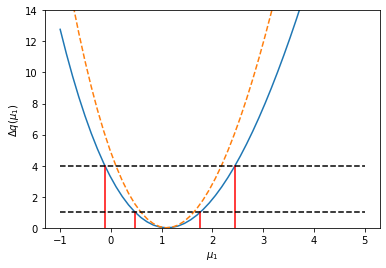

68.3% interval = (0.48,1.76)
95.4% interval = (-0.12,2.45)


In [6]:
def return_crossing(x1,y1,x2,y2,K):
  m = (y2-y1)/(x2-x1)
  c = y1-m*x1
  return (K-c)/m,K

def findIntervals(x,y,conts=[1,4]):
  xx0,yy0 = x[0],y[0]
  crossing_x = []
  for xx,yy in zip(x[1:],y[1:]):
    for K in conts:
      if (yy < K and yy0 > K) or (yy > K and yy0 < K):
        crossing_x.append(return_crossing(xx0,yy0,xx,yy,K))
    xx0=xx
    yy0=yy
  return crossing_x

# plotting
mu1_axis = numpy.linspace(-1,5,50)
z = [ delta_qmu1(data,m1,q_min) for m1 in mu1_axis]
zf = [ delta_qmu1_fix(data,m1,mu2_min,q_min) for m1 in mu1_axis]
plt.plot(mu1_axis,z)
plt.plot(mu1_axis,zf,linestyle="--")
plt.xlabel("$\\mu_{1}$")
plt.ylabel("$\Delta q(\mu_{1})$")
intervals = findIntervals(mu1_axis,z,[1,4])
[ plt.plot([x[0],x[0]],[0,x[1]],color='red') for x in intervals ]
plt.ylim((0,14))
[ plt.plot([mu1_axis[0],mu1_axis[-1]],[k,k],color='black',linestyle='--') for k in [1,4] ]
plt.show()

print("68.3%% interval = (%.2f,%.2f)"%(intervals[1][0],intervals[2][0]))
print("95.4%% interval = (%.2f,%.2f)"%(intervals[0][0],intervals[3][0]))


And we obtain the interval by finding the crossings at 1 and 4. 

If we didn't profile $\mu_{2}$, the intervals would be smaller, which shows the effect of correlations between parameters of interest. 